In [1]:
#b5 best score:

In [2]:
!pip install torch==1.1.0

     |████████████████████████████████| 676.9MB 60kB/s 
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
  Found existing installation: torch 1.2.0
    Uninstalling torch-1.2.0:
      Successfully uninstalled torch-1.2.0


In [3]:
! pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/nvidiaapex/repository/NVIDIA-apex-39e153a

/opt/conda/lib/python3.6/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-c88wz5il
Created temporary directory: /tmp/pip-req-tracker-smb3174h
Created requirements tracker '/tmp/pip-req-tracker-smb3174h'
Created temporary directory: /tmp/pip-install-mxltbgk5
Processing /kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a
  Created temporary directory: /tmp/pip-req-build-x1x_8or3
  Added file:///kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a to build tracker '/tmp/pip-req-tracker-smb3174h'
    Running setup.py (path:/tmp/pip-req-build-x1x_8or3/setup.py) egg_info for package from file:///kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a
    Running command python setup.py egg_info
    torch.__version__  =  1.1.0
    running egg_info
    creating pip-egg

In [4]:
import cv2
import matplotlib.pyplot as plt
from os.path import isfile
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import os
from PIL import Image, ImageFilter
print(os.listdir("../input"))
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD, RMSprop
import time
from torch.autograd import Variable
import torch.functional as F
from tqdm import tqdm
from sklearn import metrics
import urllib
import pickle
import cv2
import torch.nn.functional as F
from torchvision import models
import seaborn as sns
import random
from apex import amp
from sklearn.utils.class_weight import compute_class_weight
import sys
import hashlib
from joblib import Parallel, delayed
import psutil
import h5py

['nvidiaapex', 'resized-2015-2019-blindness-detection-images', 'aptos2019-blindness-detection', 'efficientnet', 'retinopathy-train-2015', 'efficientnet-pytorch']


In [5]:
from albumentations import (
    RandomBrightnessContrast,
    Compose, RandomSizedCrop,RandomSunFlare,Cutout
)

In [6]:
package_path = '../input/efficientnet/efficientnet-pytorch/EfficientNet-PyTorch/'
sys.path.append(package_path)

In [7]:
from efficientnet_pytorch import EfficientNet

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [9]:
seed_everything(1234)
basic_model        = 'B5'
num_classes        = 5
lr                 = 1e-3
IMG_SIZE           = 328
n_epochs           = 25
snapshot           = 1
train_batch_size   = 32
test_batch_size    = 64
step_size          = 10
accumulation_steps = 2

In [10]:
#train      = '../input/resized-2015-2019-blindness-detection-images/resized train 19/'
#test       = '../input/resized-2015-2019-blindness-detection-images/resized test 15/'
#train_2015 = '../input/resized-2015-2019-blindness-detection-images/resized train 15/'

#train_csv      = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
#train_2015_csv = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels15.csv')
#test_2015_csv  = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/testLabels15.csv').drop(['Usage'], axis=1)

#train_2015_csv.columns = ['id_code', 'diagnosis']
#test_2015_csv.columns = ['id_code', 'diagnosis']
#train_all = pd.concat([train_csv, train_2015_csv, test_2015_csv])
#train_all.reset_index(drop=True, inplace=True)

In [11]:
train      = '../input/aptos2019-blindness-detection/train_images/'
test       = '../input/aptos2019-blindness-detection/test_images/'
train_2015 = '../input/retinopathy-train-2015/rescaled_train_896/rescaled_train_896/'

train_csv      = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
train_2015_csv = pd.read_csv('../input/retinopathy-train-2015/rescaled_train_896/trainLabels.csv')

train_2015_csv.columns = ['id_code', 'diagnosis']
train_all = pd.concat([train_csv, train_2015_csv])
train_all.reset_index(drop=True, inplace=True)

train_df, val_df = train_test_split(train_all, test_size=0.1, random_state=2018, stratify=train_all.diagnosis)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
train_df.head()

,id_code,diagnosis
0,33783_right,0
1,31599_left,0
2,37829_left,4
3,12313_right,0
4,35648_left,0


In [12]:
def expand_path(p):
    p = str(p)
    if isfile(train + p + ".png"):
        return train + (p + ".png")
    if isfile(train_2015 + p + '.png'):
        return train_2015 + (p + ".png")
    if isfile(test + p + ".png"):
        return test + (p + ".png")
    return p

def expand_pathV2(p):
    p = str(p)
    if isfile(train + p + ".jpg"):
        return train + (p + ".jpg")
    if isfile(train_2015 + p + '.jpg'):
        return train_2015 + (p + ".jpg")
    if isfile(test + p + ".jpg"):
        return test + (p + ".jpg")
    return p

def p_show(imgs, label_name=None, per_row=3):
    n = len(imgs)
    rows = (n + per_row - 1)//per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(15,15))
    for ax in axes.flatten(): ax.axis('off')
    for i,(p, ax) in enumerate(zip(imgs, axes.flatten())): 
        img = Image.open(expand_path(p))
        ax.imshow(img)
        ax.set_title(train_df[train_df.id_code == p].diagnosis.values)

In [13]:
##https://www.kaggle.com/h4211819/more-information-about-duplicate
def getImageMetaData(p):
    strFile = expand_path(p)
    file = None;
    bRet = False;
    strMd5 = "";
    
    try:
        file = open(strFile, "rb");
        md5 = hashlib.md5();
        strRead = "";
        
        while True:
            strRead = file.read(8096);
            if not strRead:
                break;
            md5.update(strRead);
        #read file finish
        bRet = True;
        strMd5 = md5.hexdigest();
    except:
        bRet = False;
    finally:
        if file:
            file.close()

    return p,strMd5

In [14]:
img_meta_l = Parallel(n_jobs=psutil.cpu_count(), verbose=1)((delayed(getImageMetaData)(fp) for fp in train_all.id_code))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done 4544 tasks      | elapsed:   27.1s
[Parallel(n_jobs=2)]: Done 11044 tasks      | elapsed:   44.9s
[Parallel(n_jobs=2)]: Done 20144 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 31844 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 38788 out of 38788 | elapsed:  2.0min finished


In [15]:
img_meta_df = pd.DataFrame(np.array(img_meta_l))
img_meta_df.columns = ['id_code', 'strMd5']
train_all = train_all.merge(img_meta_df,on='id_code')

In [16]:
train_all['strMd5_count'] = train_all.groupby('strMd5').id_code.transform('count')
train_all['strMd5_nunique'] = train_all.groupby('strMd5')['diagnosis'].transform('nunique').astype('int')
train_all[train_all.strMd5_count>1].strMd5_count.value_counts()

2    238
3      9
4      4
Name: strMd5_count, dtype: int64

In [17]:
train_duplicated = train_all[(train_all.strMd5_count>1)]
print('There are {} deplicated pictures.'.format(len(train_duplicated)))
diagnosis_no_unique = train_duplicated[train_duplicated.strMd5_nunique != 1]
print('There are {} deplicated pictures with different dignosis.'.format(len(diagnosis_no_unique)))

There are 251 deplicated pictures.
There are 62 deplicated pictures with different dignosis.


In [18]:
diagnosis_unique = train_duplicated[train_duplicated.strMd5_nunique == 1]
strMd5_dict = {}
for strMd5 in diagnosis_unique.strMd5.values:
    id_codes = list(diagnosis_unique[diagnosis_unique.strMd5 == strMd5].id_code.values)
    strMd5_dict[strMd5] = id_codes

In [19]:
train2clear = train_all.set_index('id_code')
print('before:', len(train2clear))
left_image = 1
for strMd5, id_codes in strMd5_dict.items():
    num_images = len(id_codes)
    num_delete = num_images - left_image
    delete_id_code = random.sample(id_codes, num_delete)
    train2clear = train2clear.drop(delete_id_code)
print('after:', len(train2clear))

before: 38788
after: 38692


In [20]:
train2clear.reset_index(drop=False, inplace=True)
train2clear.to_csv('cleared_df.csv',index=None)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [21]:
train2clear.head()

,id_code,diagnosis,strMd5,strMd5_count,strMd5_nunique
0,000c1434d8d7,2,e6155d8339d40577f97a5ce270aa81d1,1,1
1,001639a390f0,4,8f98205b18dfcc9111fe97037d9fe5ba,1,1
2,0024cdab0c1e,1,43e417a95e1259bc318493e399670cb8,1,1
3,002c21358ce6,0,f96db7f8fc458a804b0db13739bc976d,1,1
4,005b95c28852,0,17ecb0becd4bd280b3572ad31dce75b9,1,1


In [22]:
train_df, val_df = train_test_split(train2clear, test_size=0.1, random_state=2018, stratify=train2clear.diagnosis)#
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
train_df.head()

,id_code,diagnosis,strMd5,strMd5_count,strMd5_nunique
0,28f73575e1f2,0,f098cbb45e3442036a76a2e446f2c7d0,1,1
1,40749_right,0,3182f0f791f6a9095fe6a2c8962f3f40,1,1
2,17387_left,2,1066a9173de6adece2314bbdd83b233a,1,1
3,17719_right,0,792585889e8a984b0df812eb94b0f9e0,1,1
4,39747_left,4,3dd2d639e307cdaf022c554c44b10141,1,1


## Data Augment

In [23]:
def toCLAHEgreen(img):  
    clipLimit=2.0 
    tileGridSize=(8, 8)  
    img = np.array(img)     
    green_channel = img[:, :, 1]    
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cla = clahe.apply(green_channel) 
    
    return cla

In [24]:
class MyDataset(Dataset):
    
    def __init__(self, dataframe, h5_file_name, argument=None, transform=None):
        self.df = dataframe
        self.transform = transform
        self.argument  = argument
        self.h5_file_name = h5_file_name
        
        with h5py.File(h5_file_name, 'r') as hdf5_file:
            self.image_names_in_h5 = np.array(hdf5_file.get('id_code')) 
            
        self.h5_dataset = None

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        label = self.df.diagnosis.values[idx]
        
        image_name = self.df.id_code.values[idx]
        image_idx_in_h5 = np.where(self.image_names_in_h5 == image_name.encode())[0][0] 
        if self.h5_dataset is None:
            self.h5_dataset = h5py.File(self.h5_file_name, 'r')['images']
        image = self.h5_dataset[image_idx_in_h5]
        #image[:, :, 1] = toCLAHEgreen(image)
        
        if self.argument:
            augmented = self.argument(image=image)
            image = augmented['image']
            image = transforms.ToPILImage()(image.astype(np.uint8))
        else:
            image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)
        
        return image, label

h5_file_name = '../input/train-croped/train_images.h5'

In [25]:
def resize_images(img, desired_size = 1024):
    try:
    
        img = cv2.copyMakeBorder(img,10,10,10,10,cv2.BORDER_CONSTANT,value=[0,0,0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    
        contours,hierarchy = cv2.findContours(gray,
                                              cv2.RETR_EXTERNAL,
                                              cv2.CHAIN_APPROX_SIMPLE)
        contours = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(contours)

        if w>200 and h>200:
            new_img = img[y:y+h,x:x+w]
            height, width, _= new_img.shape

            if max([height, width]) > desired_size:
                ratio = float(desired_size/max([height, width]))
                new_img = cv2.resize(new_img, 
                                 tuple([int(width*ratio), int(height*ratio)]), 
                                 interpolation = cv2.INTER_CUBIC)
            return new_img
        else:
            return img
    except:
        return img

In [26]:
class MyDatasetV2(Dataset):
    
    def __init__(self, dataframe, argument=None, transform=None):
        self.df = dataframe
        self.transform = transform
        self.argument  = argument
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        label = self.df.diagnosis.values[idx]
        
        p = self.df.id_code.values[idx]
        p_path = expand_path(p)
        image = cv2.imread(p_path)
        image = resize_images(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        
        if self.argument:
            augmented = self.argument(image=image)
            image     = augmented['image']
            
        image = transforms.ToPILImage()(image.astype(np.uint8))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [27]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.45, contrast=0.45),
    transforms.RandomAffine(degrees=360, scale=(1.0, 1.3)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.45, contrast=0.45),
    transforms.RandomAffine(degrees=0, scale=(1.0, 1.3)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trainset     = MyDatasetV2(train_df, transform = train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=4)
valset       = MyDatasetV2(val_df, transform = val_transform)
val_loader   = torch.utils.data.DataLoader(valset, batch_size=test_batch_size, shuffle=False, num_workers=4)

In [28]:
plot = True

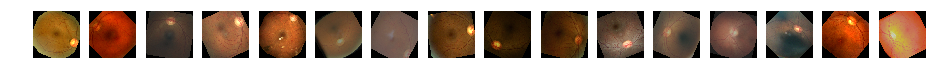

In [29]:
if plot:
    max_images = 16
    grid_width = 16
    grid_height = int(max_images / grid_width)
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
    plot_transform = transforms.Compose([transforms.ColorJitter(brightness=0.45, contrast=0.45),
                                         transforms.RandomAffine(degrees=0, scale=(1.0, 1.3)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.RandomRotation(360),
                                         transforms.ToTensor()])
    plot_dataset  = MyDatasetV2(train_df, transform = plot_transform) #argument=AUGMENTATIONS_TRAIN)
    for i, ax in zip(range(max_images), axs):
        image, label = plot_dataset[i]
        ax.imshow(transforms.ToPILImage()(image))
        ax.axis('off')

In [30]:
if basic_model == "B5": 
    model = EfficientNet.from_name('efficientnet-b5')
    model.load_state_dict(torch.load('../input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth'))
elif basic_model == "B4":
    model = EfficientNet.from_name('efficientnet-b4')
    model.load_state_dict(torch.load('../input/efficientnet-pytorch/efficientnet-b4-e116e8b3.pth'))
in_features = model._fc.in_features
model._fc   = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features, num_classes))
model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [31]:
from sklearn.metrics import cohen_kappa_score 

In [32]:
#https://github.com/huggingface/pytorch-transformers

from torch.optim.lr_scheduler import LambdaLR
import math

class WarmupCosineSchedule(LambdaLR):
    """ Linear warmup and then cosine decay.
        Linearly increases learning rate from 0 to 1 over `warmup_steps` training steps.
        Decreases learning rate from 1. to 0. over remaining `t_total - warmup_steps` steps following a cosine curve.
        If `cycles` (default=0.5) is different from default, learning rate follows cosine function after warmup.
    """
    def __init__(self, optimizer, warmup_steps, t_total, cycles=.5, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        self.cycles = cycles
        super(WarmupCosineSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1.0, self.warmup_steps))
        # progress after warmup
        progress = float(step - self.warmup_steps) / float(max(1, self.t_total - self.warmup_steps))
        return max(0.0, 0.5 * (1. + math.cos(math.pi * float(self.cycles) * 2.0 * progress)))

In [33]:
weight_pow = 0.3
label_counts = train_all['diagnosis'].value_counts().values
class_weight = (label_counts[:] / label_counts.sum())**(-weight_pow)

# normalize so that 1st class has a weight of 1
class_weight /= class_weight[0]
class_weight = torch.FloatTensor(class_weight)

In [34]:
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss(weight=class_weight).cuda()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)

In [35]:
def train_model(epoch):
    model.train() #訓練モード
    avg_loss = 0.
    optimizer.zero_grad()
    for idx, (imgs, labels) in enumerate(train_loader):
        imgs_train, labels_train = imgs.cuda(), labels.cuda()
        output_train = model(imgs_train)
        loss = criterion(output_train,labels_train)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
           # Wait for several backward steps
        optimizer.step()                              # Now we can do an optimizer step
        optimizer.zero_grad()
        avg_loss += loss.item() / len(train_loader)
        
    return avg_loss

def test_model():
    score = 0.
    avg_val_loss = 0.
    predicts = np.zeros(len(valset))
    truths = np.zeros(len(valset))
    
    model.eval() #実行モード
    with torch.no_grad():
        for idx, (imgs, labels) in enumerate(val_loader):
            start = idx*test_batch_size
            end   = min(start + test_batch_size, len(valset))
            imgs_vaild, labels_vaild = imgs.cuda(), labels.cuda()
            output_test = model(imgs_vaild)
            avg_val_loss += criterion(output_test, labels_vaild.squeeze()).item() / len(val_loader)
            output = torch.softmax(output_test, dim=1)
            
            predicts[start:end] =  np.argmax(output.detach().cpu().numpy(), axis=1).flatten()
            truths[start:end]=  labels.detach().cpu().numpy().flatten()
            
    score = cohen_kappa_score(np.array(truths), predicts, weights='quadratic')
    
    return avg_val_loss, score

In [36]:
best_avg_loss = 100.0
best_acc      = 0.0
i = 0
for epoch in range(n_epochs):
    
    
    if i == 5: break
    print(optimizer.param_groups[0]['lr'])
    start_time   = time.time()
    avg_loss     = train_model(epoch)
    avg_val_loss, score = test_model()
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t score={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, avg_val_loss, score, elapsed_time))
    
    if best_avg_loss > avg_val_loss:
        i = 0
        best_avg_loss = avg_val_loss 
        best_param_loss = model.state_dict()
    else:
        i += 1
    
    if score > best_acc:
        best_acc = score
        best_param_acc = model.state_dict()

    scheduler.step()
    
torch.save(best_param_loss, 'weight_loss_best.pt')
torch.save(best_param_acc, 'weight_acc_best.pt')

0.001
Epoch 1/25 	 loss=0.9005 	 val_loss=0.8897 	 score=0.6452 	 time=1329.66s
0.001
Epoch 2/25 	 loss=0.8015 	 val_loss=0.8570 	 score=0.6722 	 time=1335.11s
0.001
Epoch 3/25 	 loss=0.7708 	 val_loss=0.7699 	 score=0.7246 	 time=1324.04s
0.001
Epoch 4/25 	 loss=0.7445 	 val_loss=0.7804 	 score=0.7167 	 time=1327.04s
0.001
Epoch 5/25 	 loss=0.7255 	 val_loss=0.7229 	 score=0.7181 	 time=1324.12s
0.001
Epoch 6/25 	 loss=0.7103 	 val_loss=0.6968 	 score=0.7585 	 time=1321.17s
0.001
Epoch 7/25 	 loss=0.7004 	 val_loss=0.6707 	 score=0.7805 	 time=1320.45s
0.001
Epoch 8/25 	 loss=0.6888 	 val_loss=0.6852 	 score=0.7811 	 time=1321.39s
0.001
Epoch 9/25 	 loss=0.6754 	 val_loss=0.7851 	 score=0.7333 	 time=1325.59s
0.001
Epoch 10/25 	 loss=0.6715 	 val_loss=0.6870 	 score=0.7883 	 time=1323.09s
0.0001
Epoch 11/25 	 loss=0.6163 	 val_loss=0.6105 	 score=0.8081 	 time=1322.58s
0.0001
Epoch 12/25 	 loss=0.5906 	 val_loss=0.6241 	 score=0.8089 	 time=1324.41s
0.0001
Epoch 13/25 	 loss=0.5838 	 